# NYC Taxi Fare Starter Kernel - Simple Linear Model (Kaggle)

In [1]:
import numpy as np
from pandas import read_csv
import matplotlib.pyplot as plt

## Setup training data
Let's read in only 1M rows of the training data (The entire dataset is about 55M rows).

In [2]:
train_df =  read_csv('train.csv', nrows = 10_000_000)
train_df.shape

(10000000, 8)

In [3]:
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [4]:
train_df.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

Let's create two new features in our training set representing the "travel vector" between the start and end points of the taxi ride, in both longitude and latitude coordinates. We'll take the absolute value since we're only interested in distance traveled. Use a helper function since we'll want to do the same thing for the test set later.

In [5]:
# Given a dataframe, add two new features 'abs_diff_longitude' and
# 'abs_diff_latitude' reprensenting the "Manhattan vector" from
# the pickup location to the dropoff location.
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()

In [6]:
add_travel_vector_features(train_df)

## Explore and prune outliers
Let's see if there are any NaNs in the dataset.

In [7]:
print(train_df.isnull().sum())

key                    0
fare_amount            0
pickup_datetime        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude     69
dropoff_latitude      69
passenger_count        0
abs_diff_longitude    69
abs_diff_latitude     69
dtype: int64


There are a small amount, so let's remove them from the dataset.

In [8]:
print('Old size: %d' % len(train_df))
train_df = train_df.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(train_df))

Old size: 10000000
New size: 9999931


Now let's quickly plot a subset of our travel vector features to see its distribution.

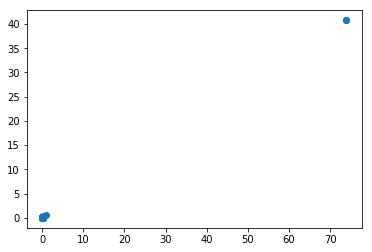

In [9]:
plot = train_df.iloc[:2000]
plt.scatter(plot.abs_diff_longitude, plot.abs_diff_latitude)
plt.show()

We expect most of these values to be very small (likely between 0 and 1) since it should all be differences between GPS coordinates within one city. For reference, one degree of latitude is about 69 miles. However, we can see the dataset has extreme values which do not make sense. Let's remove those values from our training set. Based on the scatterplot, it looks like we can safely exclude values above 5 (though remember the scatterplot is only showing the first 2000 rows...)

In [10]:
print('Old size: %d' % len(train_df))
train_df = train_df[(train_df.abs_diff_longitude < 5.0) & (train_df.abs_diff_latitude < 5.0)]
print('New size: %d' % len(train_df))

Old size: 9999931
New size: 9979187


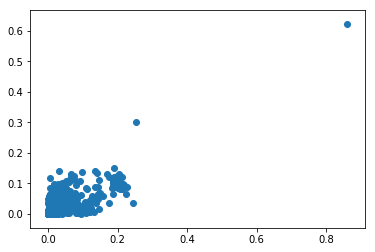

In [11]:
plot = train_df.iloc[:2000]
plt.scatter(plot.abs_diff_longitude, plot.abs_diff_latitude)
plt.show()

Ok, it is reasonable.

In [12]:
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,0.002701,0.009041
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,0.036780,0.070701
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,0.008504,0.010708
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,0.004437,0.024949
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,0.011440,0.015754


## Train the model

In [13]:
X_train = train_df.iloc[:,[8,9]].values
y_train = train_df.iloc[:,1].values

In [14]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [15]:
print(model.coef_.round(3))
print(model.intercept_.round(3))

[147.162  76.955]
6.395


## Make predictions on the test set
Let's load up our test inputs and predict the **fare_amounts** for them using our learned weights!

In [16]:
test_df = read_csv('test.csv')
test_df.dtypes

key                   object
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [17]:
test_df.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


In [18]:
test_df.shape

(9914, 7)

In [19]:
# Reuse the above helper functions to add our features and generate the input matrix.
add_travel_vector_features(test_df)

In [20]:
test_df.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1,0.008110,0.019970
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1,0.012024,0.019817
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1,0.002870,0.005121
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1,0.009288,0.016172
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1,0.022519,0.045348


In [21]:
X_test = test_df.iloc[:,[7,8]]

In [22]:
y_pred = model.predict(X_test).round(2)

In [24]:
sample = read_csv('sample_submission.csv')
sample.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.35
1,2015-01-27 13:08:24.0000003,11.35
2,2011-10-08 11:53:44.0000002,11.35
3,2012-12-01 21:12:12.0000002,11.35
4,2012-12-01 21:12:12.0000003,11.35


In [ ]:
from pandas import DataFrame

# Write the predictions to a CSV file which we can submit to the competition.

submission = DataFrame(
    {'key': test_df.key, 'fare_amount': y_pred},
    columns = ['key', 'fare_amount'])

submission.head()
#submission.to_csv('submission.csv', index = False)

#print(os.listdir('.'))

In [25]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

print('RMSE: %.2f' % np.sqrt(mean_squared_error(sample.fare_amount, y_pred)).round(2))
print('MAE: %.2f' % mean_absolute_error(sample.fare_amount, y_pred).round(2))

RMSE: 6.78
MAE: 3.72


RMSE = 5.74 is obtained for the true **fare_amount** in test.csv using this basic linear model.  

## Ideas for Improvement
The output here will score an RMSE of $5.74, but you can do better than that! Here are some suggestions:

Use more columns from the input data. Here we're only using the start/end GPS points from columns [pickup|dropoff]_[latitude|longitude]. Try to see if the other columns -- pickup_datetime and passenger_count -- can help improve your results.

- Use absolute location data rather than relative. Here we're only looking at the difference between the start and end points, but maybe the actual values -- indicating where in NYC the taxi is traveling -- would be useful.
- Use a non-linear model to capture more intricacies within the data.
- Try to find more outliers to prune, or construct useful feature crosses.
- Use the entire dataset -- here we're only using about 20% of the training data!

## Random Forest Regressor

In [26]:
from pandas import read_csv
from pandas import to_datetime
import numpy as np
import matplotlib.pyplot as plt

In [27]:
# Read the dataset
train_df =  read_csv('train.csv', nrows = 100_000)

In [28]:
train_df['pickup_datetime'] = to_datetime(train_df['pickup_datetime'], infer_datetime_format=True)

In [29]:
train_df['hour'] = train_df['pickup_datetime'].dt.hour
train_df['dayofweek'] = train_df['pickup_datetime'].dt.dayofweek
#train_df['weekday_name'] = train_df['pickup_datetime'].dt.weekday_name

In [30]:
train_df.dtypes

key                          object
fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
hour                          int64
dayofweek                     int64
dtype: object

In [31]:
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,dayofweek
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,17,0
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,16,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,0,3
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,4,5
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,7,1


## Explore and prune outliers
Let's see if there are any NaNs in the dataset.

In [32]:
print(train_df.isnull().sum())

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
hour                 0
dayofweek            0
dtype: int64


In [33]:
# drop rows with missing values
print('Old size: %d' % len(train_df))
train_df = train_df.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(train_df))

Old size: 100000
New size: 100000


In [34]:
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,dayofweek
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,11.354652,-72.494682,39.914481,-72.490967,39.919053,1.673820,13.495110,3.036180
std,9.716777,10.693934,6.225686,10.471386,6.213427,1.300171,6.507434,1.949484
min,-44.900000,-736.550000,-74.007670,-84.654241,-74.006377,0.000000,0.000000,0.000000
25%,6.000000,-73.992041,40.734996,-73.991215,40.734182,1.000000,9.000000,1.000000
50%,8.500000,-73.981789,40.752765,-73.980000,40.753243,1.000000,14.000000,3.000000
75%,12.500000,-73.966982,40.767258,-73.963433,40.768166,2.000000,19.000000,5.000000
max,200.000000,40.787575,401.083332,40.851027,404.616667,6.000000,23.000000,6.000000


There are strange values for logitudes and latitudes, as well as for passengers.

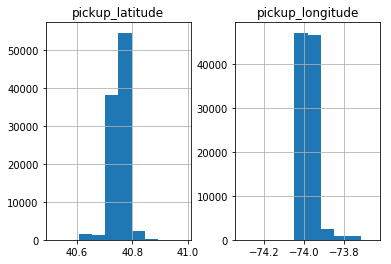

In [35]:
train_df = train_df[(train_df['pickup_latitude'] > 40.5) & (train_df['pickup_latitude'] < 41)]
train_df = train_df[(train_df['pickup_longitude'] > -74.4) & (train_df['pickup_longitude'] < -73.6)]
train_df.hist(column = ['pickup_longitude','pickup_latitude'])
plt.show()

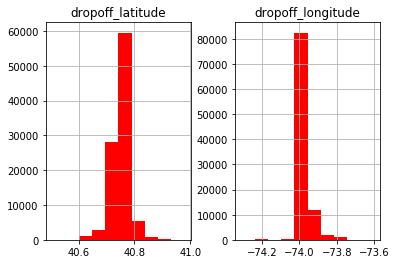

In [36]:
train_df = train_df[(train_df['dropoff_latitude'] > 40.5) & (train_df['dropoff_latitude'] < 41)]
train_df = train_df[(train_df['dropoff_longitude'] > -74.4) & (train_df['dropoff_longitude'] < -73.6)]
train_df.hist(column = ['dropoff_longitude','dropoff_latitude'], color = 'red')
plt.show()

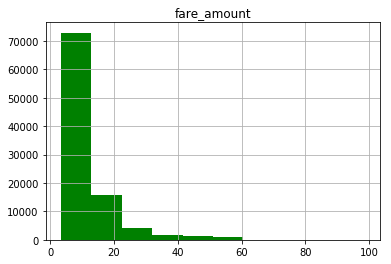

In [37]:
train_df = train_df[(train_df['fare_amount'] > 3) & (train_df['fare_amount'] < 100.1)]
train_df.hist(column = ['fare_amount'], color = 'green')
plt.show()

In [38]:
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,dayofweek
count,96989.000000,96989.000000,96989.000000,96989.000000,96989.000000,96989.000000,96989.000000,96989.000000
mean,11.356657,-73.975500,40.750952,-73.974326,40.751386,1.676283,13.500325,3.037097
std,9.344204,0.034477,0.026925,0.034316,0.030881,1.301583,6.501796,1.949476
min,3.300000,-74.312932,40.509960,-74.308235,40.505648,0.000000,0.000000,0.000000
25%,6.000000,-73.992277,40.736679,-73.991395,40.735779,1.000000,9.000000,1.000000
50%,8.500000,-73.982094,40.753531,-73.980447,40.753961,1.000000,14.000000,3.000000
75%,12.500000,-73.968405,40.767648,-73.965253,40.768461,2.000000,19.000000,5.000000
max,98.750000,-73.652179,40.988240,-73.602318,40.978090,6.000000,23.000000,6.000000


In [39]:
train_df.shape

(96989, 10)

In [40]:
import math
from math import radians, cos, sin, asin, sqrt
def distance(lat1, lng1, lat2, lng2):
    #return distance as meter if you want km distance, remove "* 1000"
    radius = 6371

    dLat = (lat2-lat1) * np.pi / 180
    dLng = (lng2-lng1) * np.pi / 180

    lat1 = lat1 * np.pi / 180
    lat2 = lat2 * np.pi / 180

    val = np.sin(dLat/2) * np.sin(dLat/2) + np.sin(dLng/2) * np.sin(dLng/2) * np.cos(lat1) * np.cos(lat2)    
    ang = 2 * np.arctan2(np.sqrt(val), np.sqrt(1-val))
    return radius * ang

In [41]:
train_df['dist'] = distance(train_df['pickup_latitude'], train_df['pickup_longitude'],
                            train_df['dropoff_latitude'], train_df['dropoff_longitude'])

In [42]:
# Define function to create new features the components of the "travel vector"
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()
    #df['vector_modulus'] = (df.abs_diff_longitude**2 + df.abs_diff_latitude**2) # NOT PROPORTIONAL TO DIST

In [43]:
# Apply the function and create the features
add_travel_vector_features(train_df)

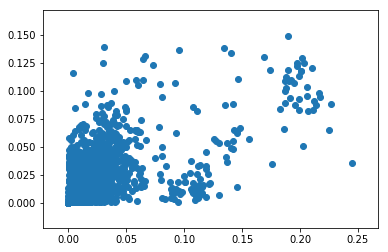

In [44]:
plot = train_df.iloc[:2000]
plt.scatter(plot.abs_diff_longitude, plot.abs_diff_latitude)
plt.show()

In [45]:
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,dayofweek,dist,abs_diff_longitude,abs_diff_latitude
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,17,0,1.030764,0.002701,0.009041
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,16,1,8.450134,0.036780,0.070701
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,0,3,1.389525,0.008504,0.010708
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,4,5,2.799270,0.004437,0.024949
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,7,1,1.999157,0.011440,0.015754


## Train the model

In [46]:
X = train_df.iloc[:,[3,4,5,6,10,11,12]].values
y = train_df.iloc[:,1].values

In [47]:
from sklearn.model_selection import train_test_split

seed = 0

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = seed)

In [51]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

model = RandomForestRegressor(n_estimators=20, random_state=seed, n_jobs = -1)
model.fit(X_train, y_train)

scores = cross_val_score(model, X_train, y_train, cv=3, scoring=make_scorer(mean_squared_error))
print('RMSE: %.3f +/- %.3f' % (np.sqrt(np.mean(scores)).round(2), np.sqrt(np.std(scores))))

RMSE: 3.890 +/- 0.738


In [52]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

y_pred = model.predict(X_test)
print('RMSE: %.2f' % np.sqrt(mean_squared_error(y_test, y_pred)).round(2))
print('MAE: %.2f' % mean_absolute_error(y_test, y_pred).round(2))

RMSE: 3.93
MAE: 2.15


## Make predictions on the test set
Let's load up our test inputs and predict the **fare_amounts** for them using our learned weights!

In [ ]:
test_df = read_csv('test.csv')
print(test_df.shape)

In [ ]:
test_df['pickup_datetime'] = to_datetime(test_df['pickup_datetime'], infer_datetime_format=True)

In [ ]:
test_df['hour'] = test_df['pickup_datetime'].dt.hour
test_df['dayofweek'] = test_df['pickup_datetime'].dt.dayofweek

In [ ]:
test_df.describe()

In [ ]:
test_df['dist'] = distance(test_df['pickup_latitude'], test_df['pickup_longitude'],
                            test_df['dropoff_latitude'], test_df['dropoff_longitude'])

In [ ]:
add_travel_vector_features(test_df)

In [ ]:
test_df.head()

In [ ]:
X_testF = test_df.iloc[:,[2,3,4,5,9,10,11]]

In [ ]:
y_predF = model.predict(X_testF).round(2)

In [ ]:
from pandas import DataFrame

# Write the predictions to a CSV file which we can submit to the competition.

submission = DataFrame(
    {'key': test_df.key, 'fare_amount': y_predF},
    columns = ['key', 'fare_amount'])

submission.head()
submission.to_csv('submission.csv', index = False)

#print(os.listdir('.'))

# Out-Of-Core Learning (to be done...)

In [1]:
import numpy as np
from pandas import read_csv
import pyprind

In [2]:
# Read the dataset
train_df =  read_csv('train.csv', nrows = 5)
train_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [33]:
def stream_docs(path, delimiter = ','):
    with open(path, 'r') as f:
        next(f) # skip header
        for record in f:
            line = record.split(delimiter)
            x = float(line[4])
            target = float(line[1])
            yield x, target

In [34]:
# let's verify if the stream_docs function works correctly
next(stream_docs(path='train.csv'))

(40.721319, 4.5)

In [35]:
def get_minibatch(doc_stream, size):
    docs, y = [], []
    try:
        for _ in range(size):
            x, target = next(doc_stream)
            docs.append(x)
            y.append(target)
    except StopIteration:
        return None, None
    return docs, y

In [37]:
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor

#model = MLPRegressor()
model = SGDRegressor()

doc_stream = stream_docs(path='train.csv')

In [58]:
pbar = pyprind.ProgBar(10)

for _ in range(10):
    X_train, y_train = get_minibatch(doc_stream, size=10)
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    if not X_train:
        break
    #model.partial_fit(X_train, y_train)
    print(X_train, y_train)
    pbar.update()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [56]:
y_train.shape

(1,)

In [46]:
a = [[1,2],[3,4]]
b = np.array(a)
b.shape

(2, 2)